In [5]:
# univariate cnn lstm example
from numpy import array
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from pandas import read_csv
from math import sqrt


# split a univariate sequence into samples

# transformem les dades a format seqüencia d'entrada i seqüencia de sortida
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix >= len(sequence):
            break
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[out_end_ix]
        #if (len(seq_y)==n_steps_out and len(seq_x)==n_steps_in):
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def train_test (n_steps_in, n_steps_out, propTrainTest, dataset):
    
    n_steps_in, n_steps_out = n_steps_in, n_steps_out
    # split train test
    X, y = split_sequence(dataset, n_steps_in, n_steps_out)
    
    train_size = int(len(X) * propTrainTest)
    test_size = len(dataset) - train_size
    train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
    train_Y, test_Y = y[0:train_size], y[train_size:len(y)]
    
    return (train_X, test_X, train_Y, test_Y)

# fixem random seed
np.random.seed(7)

dadesSau = read_csv('dadesSau.csv', sep=';',header=0, index_col=0)
dataframe = pd.DataFrame(dadesSau.loc[dadesSau.index >= '2009-01-01']['Volum'])
dataset = dataframe.values
dataset = dataset.astype('float32')

# Normalitzem

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = [item for sublist in dataset for item in sublist]

n_steps_in = 17
n_steps_out = 15
propTrainTest = 0.8
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, dataset)

In [6]:
model = SVR(kernel='rbf', C=75, gamma=0.1, epsilon=0.003)
model.fit(train_X, train_Y)
testPredict = model.predict(test_X)

In [7]:
test_YR = np.array(test_Y).reshape((test_Y.shape[0], 1))
test_YR = scaler.inverse_transform(test_YR)
test_XR = scaler.inverse_transform(test_X)
testPredict = np.array(testPredict).reshape((testPredict.shape[0], 1))
testPredict = scaler.inverse_transform(testPredict)

def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)


8.819254279981456


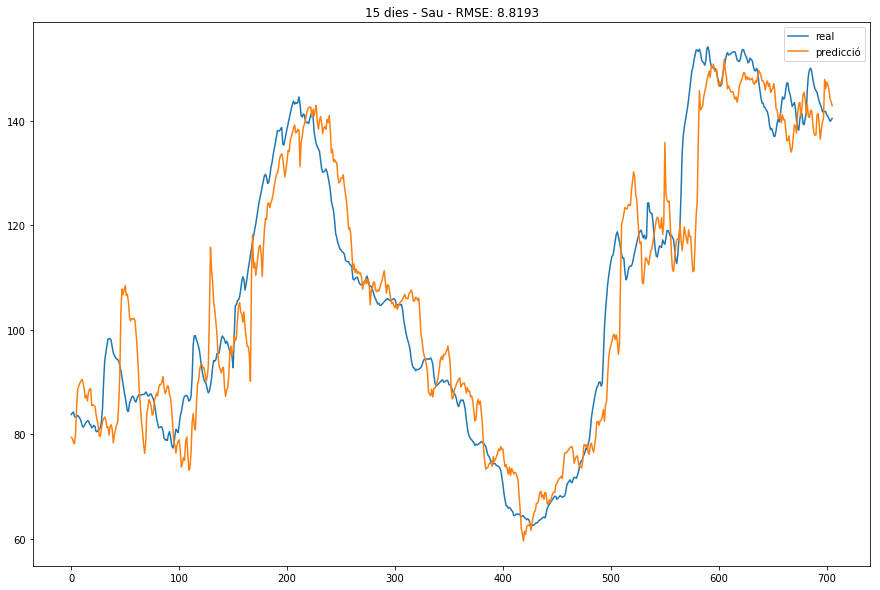

In [8]:
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '15 dies - Sau - RMSE: '+str(round(RMSE_days[0],4))

plt.plot(test_YR, label='real')
plt.plot(testPredict, label='predicció')
plt.legend()
plt.title(title1)


plt.show()